# **Photo-realistic single image Super-Resolution model using a Generative Adversarial Network**
## Purpose
The purpose of this notebook is to train a photo-realistic single image Super-Resolution model using a Generative Adversarial Network implemented in Keras.

We are going to implement [this model](https://github.com/deepak112/Keras-SRGAN) using `TFRecordDatasets`.

For more about topic check [Single Image Super Resolution Using GANs — Keras](https://medium.com/@birla.deepak26/single-image-super-resolution-using-gans-keras-aca310f33112)

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look real, while a discriminator ("the art critic") learns to tell real images apart from fakes.

During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.

## Setup
### Library import

**Solve "No Algorithm Worked" [Error](https://stackoverflow.com/questions/59340465/how-to-solve-no-algorithm-worked-keras-error)**

In [1]:
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession

#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

In [1]:
import tensorflow as tf
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**Setup software libraries**

In [2]:
import os
import time
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

from vizzDL import datasets

## Load and prepare the dataset

In original paper Low Resolution (LR) images are scaled between [0,1] and High Resolution (HR) images are scaled between [-1,1]. But here we scaled both LR and HR images between [-1,1].

In [3]:
TFRecord = datasets.read_TFRecords(folder_path = '../../datasets/processed/Models/', dataset_name = 'L8_S2_SR',\
                                   normalize_rgb = True, norm_range = [-1,1], batch_size=64, shuffle_size=2000, scaling_factor=2)

In [4]:
training_dataset = TFRecord.get_training_dataset()
validation_dataset = TFRecord.get_validation_dataset()

In [5]:
training_dataset

<RepeatDataset shapes: ((None, 64, 64, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32)>

**Read example record**

In [6]:
iterator = iter(training_dataset)
image, label = iterator.get_next()
image = image.numpy()
label = label.numpy()
print("Input shape:", image.shape)
print("Output shape:", label.shape)

Input shape: (64, 64, 64, 3)
Output shape: (64, 128, 128, 3)


Text(0.5, 1.0, 'Sentinel 2 RGB')

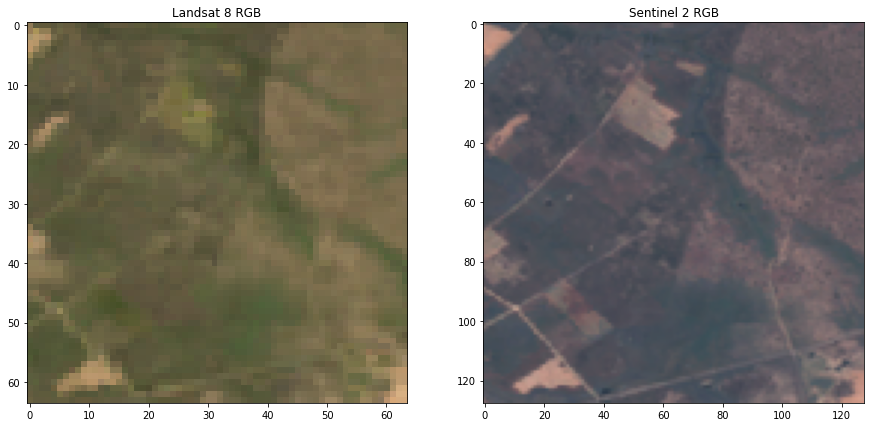

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

ax[0].imshow(((image[1,:,:,:3]+1)*127.5).astype(int))
ax[0].set_title('Landsat 8 RGB')

ax[1].imshow(((label[1,:,:,:3]+1)*127.5).astype(int))
ax[1].set_title('Sentinel 2 RGB')

## Create the models
### Generator Network
Number of Residual blocks used are 16.

In [9]:
from tensorflow.keras.layers import Dense, Flatten, Input, add
from tensorflow.keras.layers import Conv2D, UpSampling2D,  Conv2DTranspose 
from tensorflow.keras.layers import Activation, PReLU, LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

In [10]:
# Residual block
def res_block_gen(model, kernal_size, filters, strides):
    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = add([gen, model])
    
    return model
    
    
def up_sampling_block(model, scale, kernal_size, filters, strides):
    
    # In place of Conv2D and UpSampling2D we can also use Conv2DTranspose (Both are used for Deconvolution)
    # Even we can have our own function for deconvolution (i.e one made in Utils.py)
    #model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = scale)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model


# Network Architecture is same as given in Paper https://arxiv.org/pdf/1609.04802.pdf
class Generator(object):
    def __init__(self, noise_shape, scale):  
        
        self.noise_shape = noise_shape
        self.scale = scale
        
    def generator(self):
        
        gen_input = Input(shape = self.noise_shape)
     
        model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
        model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
        
        gen_model = model
        
        # Using 16 Residual Blocks
        for index in range(16):
            model = res_block_gen(model, 3, 64, 1)
     
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
        model = BatchNormalization(momentum = 0.5)(model)
        model = add([gen_model, model])
     
        # Using UpSampling Blocks
        if self.scale < 4:
            model = up_sampling_block(model, self.scale, 3, 256, 1)
        elif self.scale == 4:
            for index in range(2):
                model = up_sampling_block(model, self.scale//2, 3, 256, 1)
     
        model = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(model)
        model = Activation('tanh')(model)
    
        generator_model = Model(inputs = gen_input, outputs = model, name='generator')
        return generator_model

**Use the (as yet untrained) generator to create an image.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


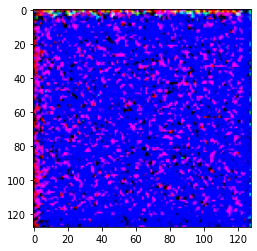

In [11]:
input_shape = (TFRecord.params['kernel_size']//TFRecord.params['scaling_factor'], TFRecord.params['kernel_size']//TFRecord.params['scaling_factor'], len(TFRecord.params['in_bands']))
scaling_factor = TFRecord.params['scaling_factor']

generator = Generator(input_shape, scaling_factor).generator()

noise = tf.random.normal([1] + list(input_shape))

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :])

### Discriminator Network
The discriminator is a CNN-based image classifier.

In [12]:
def discriminator_block(model, filters, kernel_size, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

# Network Architecture is same as given in Paper https://arxiv.org/pdf/1609.04802.pdf
class Discriminator(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape
    
    def discriminator(self):
        
        dis_input = Input(shape = self.image_shape)
        
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)
        
        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)
        
        model = Flatten()(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha = 0.2)(model)
       
        model = Dense(1)(model)
        model = Activation('sigmoid')(model) 
        
        discriminator_model = Model(inputs = dis_input, outputs = model, name='discriminator')
        
        return discriminator_model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [13]:
output_shape = (TFRecord.params['kernel_size'], TFRecord.params['kernel_size'], len(TFRecord.params['out_bands']))

discriminator = Discriminator(output_shape).discriminator()

decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5023724]], shape=(1, 1), dtype=float32)


# Train the GAN using `GradientTape`

With `GradientTape` we can customize the learning algorithm of our model while still leveraging the convenience of using [built-in methods](https://www.tensorflow.org/guide/keras/train_and_evaluate/) like `fit()`, which is requerid for training a GAN model. We can subclass the Model class and implement ourr own `train_step()` method, which is called repeatedly during `fit()`. 

Calling a model inside a `GradientTape` scope enables us to retrieve the gradients of the trainable weights of the layer with respect to a loss value. Using an optimizer instance, we can use these gradients to update these variables (which we can retrieve using `model.trainable_variables`). For an end-to-end example check [this guide](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch). 


**Based on**:
- [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan)
- [Single Image Super-Resolution with EDSR, WDSR and SRGAN](https://github.com/krasserm/super-resolution)

## Define the loss and optimizers
Define loss functions and optimizers for both models.

In [14]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Content Loss function
It is computed directly on the generator’s outputs. This first loss ensures the GAN model is oriented towards a deblurring task. It compares the outputs of the first convolutions of VGG.

In [15]:
def vgg_model(output_layer=20):
    vgg = VGG19(input_shape=(None, None, 3), include_top=False)
    return Model(vgg.input, vgg.layers[output_layer].output)

In [16]:
output_shape = (TFRecord.params['kernel_size'], TFRecord.params['kernel_size'], len(TFRecord.params['out_bands']))

vgg = vgg_model()

mean_squared_error = MeanSquaredError()

@tf.function
def content_loss(hr, sr):
    sr = preprocess_input(sr)
    hr = preprocess_input(hr)
    sr_features = vgg(sr) / 12.75
    hr_features = vgg(hr) / 12.75
    return mean_squared_error(hr_features, sr_features)

### Discriminator loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s. 

In [17]:
binary_cross_entropy = BinaryCrossentropy(from_logits=False)

def discriminator_loss(hr_out, sr_out):
    hr_loss = binary_cross_entropy(tf.ones_like(hr_out), hr_out)
    sr_loss = binary_cross_entropy(tf.zeros_like(sr_out), sr_out)
    return hr_loss + sr_loss

### Generator loss

In [18]:
def generator_loss(sr_out):
    return binary_cross_entropy(tf.ones_like(sr_out), sr_out)

### Optimizer function

In [19]:
def get_optimizer(learning_rate=1E-4):
 
    adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

generator_optimizer = get_optimizer()
discriminator_optimizer = get_optimizer()

### Save checkpoints
To save and restore models, which can be helpful in case a long running training task is interrupted.

In [20]:
batch_size = 32
batch_count = int(TFRecord.params['training_size'] / batch_size)
input_shape = (TFRecord.params['kernel_size']//TFRecord.params['scaling_factor'], TFRecord.params['kernel_size']//TFRecord.params['scaling_factor'], len(TFRecord.params['in_bands']))
output_shape = (TFRecord.params['kernel_size'], TFRecord.params['kernel_size'], len(TFRecord.params['out_bands']))
scaling_factor = TFRecord.params['scaling_factor']

TFRecord = datasets.read_TFRecords(folder_path = '../../datasets/processed/Models/', dataset_name = 'L8_S2_SR',\
                                   normalize_rgb = True, norm_range = [-1,1], batch_size=batch_size, shuffle_size=2000, scaling_factor=2)
training_dataset = TFRecord.get_training_dataset()

folder_path = '../../datasets/processed/Models/'
dataset_name = 'L8_S2_SR'
model_name = 'srgan_L8_to_S2'

optimizer = get_optimizer()

generator = Generator(input_shape, scaling_factor).generator()
discriminator = Discriminator(output_shape).discriminator()
generator_optimizer = optimizer
discriminator_optimizer = optimizer

In [21]:
model_dir_path = os.path.join(folder_path, dataset_name, model_name)
# Create directory to store the model
if not os.path.isdir(model_dir_path):
    os.mkdir(model_dir_path)

checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(model_dir_path, checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [22]:
epochs = 20

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(lr, hr):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)

        sr = generator(lr, training=True)

        hr_output = discriminator(hr, training=True)
        sr_output = discriminator(sr, training=True)

        con_loss = content_loss(hr, sr)
        gen_loss = generator_loss(sr_output)
        perc_loss = con_loss + 0.001 * gen_loss
        disc_loss = discriminator_loss(hr_output, sr_output)

    gradients_of_generator = gen_tape.gradient(perc_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return perc_loss, disc_loss

In [24]:
from tensorflow.keras.metrics import Mean
def train(dataset, epochs, steps):
    for epoch in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % epoch, '-'*15)
        start = time.time()
        
        pls_metric = Mean()
        dls_metric = Mean()
        step = 0

        for lr, hr in tqdm(dataset.take(steps)):
            step += 1
            
            pl, dl = train_step(lr, hr)
            pls_metric(pl)
            dls_metric(dl)

        # Save the model every 2 epochs
        if (epoch + 1) % 2 == 0:
            print('Saving the model')
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
        print(f'Epoch {epoch + 1}, perceptual loss = {pls_metric.result():.4f}, discriminator loss = {dls_metric.result():.4f}')
        pls_metric.reset_states()
        dls_metric.reset_states()

### Train the model

In [26]:
train(training_dataset, epochs, batch_count)

--------------- Epoch 1 ---------------


  2%|▏         | 20/875 [00:27<19:17,  1.35s/it] 


KeyboardInterrupt: 

***
# Train the GAN in `eagerly` mode
**Based on**:
- [Single Image Super Resolution Using GANs — Keras](https://medium.com/@birla.deepak26/single-image-super-resolution-using-gans-keras-aca310f33112)

### Define the loss and optimizers
Define loss functions and optimizers for both models.

**Content Loss function**

It is computed directly on the generator’s outputs. This first loss ensures the GAN model is oriented towards a deblurring task. It compares the outputs of the first convolutions of VGG.

In [14]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [15]:
class VGG_LOSS(tf.keras.losses.Loss):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape
        
    # computes VGG loss or content loss
    def vgg_loss(self, y_true, y_pred):
    
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        model.trainable = False
    
        return K.mean(K.square(model(y_true) - model(y_pred)))

**Optimizer function**

In [16]:
def get_optimizer(learning_rate=1E-4):
 
    adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

### GAN Network

In [17]:
# Combined network
def get_gan_network(discriminator, generator, input_shape, optimizer, vgg_loss):
    discriminator.trainable = False
    gan_input = Input(shape=input_shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output], name='gan')
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan

In [18]:
input_shape = (TFRecord.params['kernel_size']//TFRecord.params['scaling_factor'], TFRecord.params['kernel_size']//TFRecord.params['scaling_factor'], len(TFRecord.params['in_bands']))
output_shape = (TFRecord.params['kernel_size'], TFRecord.params['kernel_size'], len(TFRecord.params['out_bands']))
scaling_factor = TFRecord.params['scaling_factor']

generator = Generator(input_shape, scaling_factor).generator()
discriminator = Discriminator(output_shape).discriminator()

optimizer = get_optimizer()
loss = VGG_LOSS(output_shape)  

gan = get_gan_network(discriminator, generator, input_shape, optimizer, loss.vgg_loss)

In [19]:
gan.summary()

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
generator (Functional)       (None, 128, 128, 3)       1453699   
_________________________________________________________________
discriminator (Functional)   (None, 1)                 38249281  
Total params: 39,702,980
Trainable params: 1,449,475
Non-trainable params: 38,253,505
_________________________________________________________________


## Train the GAN

In [20]:
batch_size = 32
batch_count = int(TFRecord.params['training_size'] / batch_size)
input_shape = (TFRecord.params['kernel_size']//TFRecord.params['scaling_factor'], TFRecord.params['kernel_size']//TFRecord.params['scaling_factor'], len(TFRecord.params['in_bands']))
output_shape = (TFRecord.params['kernel_size'], TFRecord.params['kernel_size'], len(TFRecord.params['out_bands']))
scaling_factor = TFRecord.params['scaling_factor']

folder_path = '../../datasets/processed/Models/'
dataset_name = 'L8_S2_SR'
model_name = 'srgan_L8_to_S2'

model_dir_path = os.path.join(folder_path, dataset_name, model_name)
# Create directory to store the model
if not os.path.isdir(model_dir_path):
    os.mkdir(model_dir_path)

TFRecord = datasets.read_TFRecords(folder_path = '../../datasets/processed/Models/', dataset_name = 'L8_S2_SR',\
                                   normalize_rgb = True, norm_range = [-1,1], batch_size=batch_size, shuffle_size=2000, scaling_factor=2)
training_dataset = TFRecord.get_training_dataset()
    
    
optimizer = get_optimizer()
loss = VGG_LOSS(output_shape)

generator = Generator(input_shape, scaling_factor).generator()
discriminator = Discriminator(output_shape).discriminator()  

generator.compile(loss=loss.vgg_loss, optimizer=optimizer)
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)

gan = get_gan_network(discriminator, generator, input_shape, optimizer, loss.vgg_loss)

loss_file = open(model_dir_path + '/' + 'losses.txt' , 'w+')
loss_file.close()

In [21]:
def train(dataset, epochs, steps):
    for epoch in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % epoch, '-'*15)
        for image_lr, image_hr in tqdm(dataset.take(steps)):
            
            image_lr = image_lr.numpy()
            image_hr = image_hr.numpy()
            
            #image_lr = tf.cast(image_lr, tf.float32)
            #image_hr = tf.cast(image_hr, tf.float32)
            
            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            generated_images_sr = generator.predict(image_lr)
            
            discriminator.trainable = True
            
            d_loss_real = discriminator.train_on_batch(image_hr, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            discriminator_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(image_lr, [image_hr,gan_Y])
            
        print("discriminator_loss : %f" % discriminator_loss)
        print("gan_loss :", gan_loss)
        gan_loss = str(gan_loss)
        
        loss_file = open(model_dir_path + '/' + 'losses.txt' , 'a')
        loss_file.write('epoch%d : gan_loss = %s ; discriminator_loss = %f\n' %(epoch, gan_loss, discriminator_loss) )
        loss_file.close()

        #if e == 1 or e % 5 == 0:
        #    Utils.plot_generated_images(output_dir, e, generator, x_test_hr, x_test_lr)
        if epoch % 5 == 0:
            generator.save(model_dir_path + '/' + 'gen_model%d.h5' % epoch)
            discriminator.save(model_save_dir + 'dis_model%d.h5' % epoch)

In [22]:
dataset = training_dataset
epochs = 10
steps = batch_count

tf.config.run_functions_eagerly(True)
train(dataset, epochs, steps)

--------------- Epoch 1 ---------------


  0%|          | 0/875 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
  7%|▋         | 59/875 [01:10<16:10,  1.19s/it] 


KeyboardInterrupt: 